<a href="https://colab.research.google.com/github/jiehyunjkim/HuBMAP/blob/master/Polyp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import pandas as pd
from skimage.transform import resize
import tifffile

In [8]:
DATASET_PATH = "/content/drive/MyDrive/polyp"
TOTAL_NUM_DATA = 612
IMAGE_NPY = DATASET_PATH + "/IMG_NPY"
MASK_NPY = DATASET_PATH + "/MASK_NPY"

In [9]:
loadedimages = []
loadedmasks = []

for i in range(TOTAL_NUM_DATA):
    img_id = random.randint(1, TOTAL_NUM_DATA)
    
    loadedimages += [np.load(IMAGE_NPY + f'/{img_id}.npy', allow_pickle=True).copy()]
    loadedmasks += [np.load(MASK_NPY + f'/{img_id}.npy', allow_pickle=True).copy()]

imgs = np.asarray(loadedimages)
masks = np.asarray(loadedmasks)

In [11]:
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


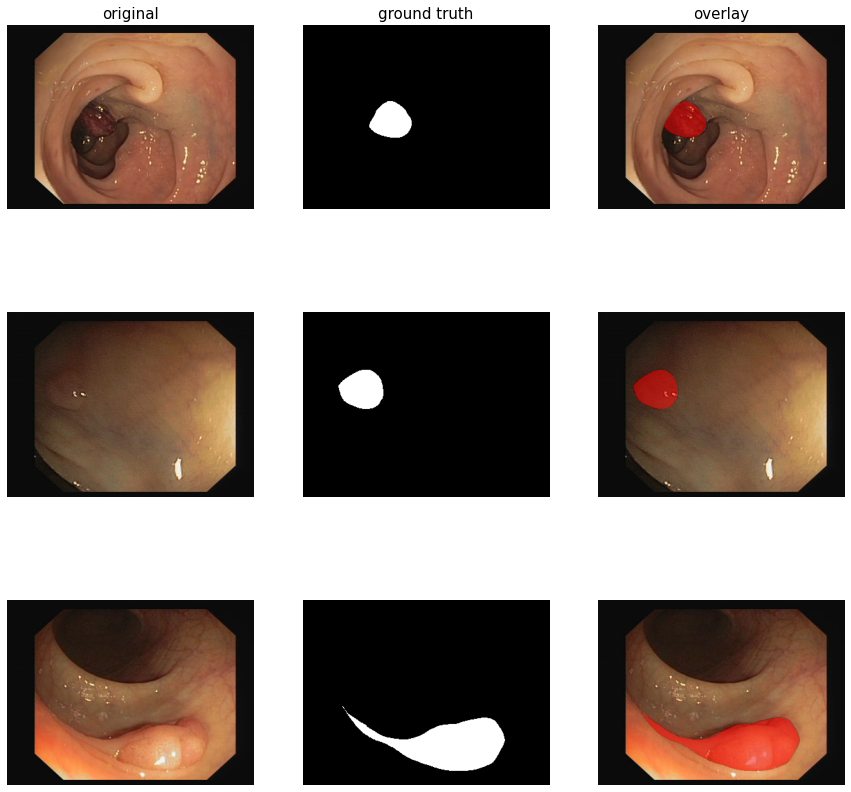

In [12]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=imgs, mask_imgs=masks, nm_img_to_plot=3, figsize=5)

In [13]:
x = np.asarray(imgs,dtype=np.float32)/255
y = np.asarray(masks,dtype=np.float32)/255

In [14]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

(612, 288, 384, 3) (612, 288, 384, 1)


In [15]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.145, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (523, 288, 384, 3)
y_train:  (523, 288, 384, 1)
x_val:  (89, 288, 384, 3)
y_val:  (89, 288, 384, 1)


In [16]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [17]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)

(2, 288, 384, 3) (2, 288, 384, 1)


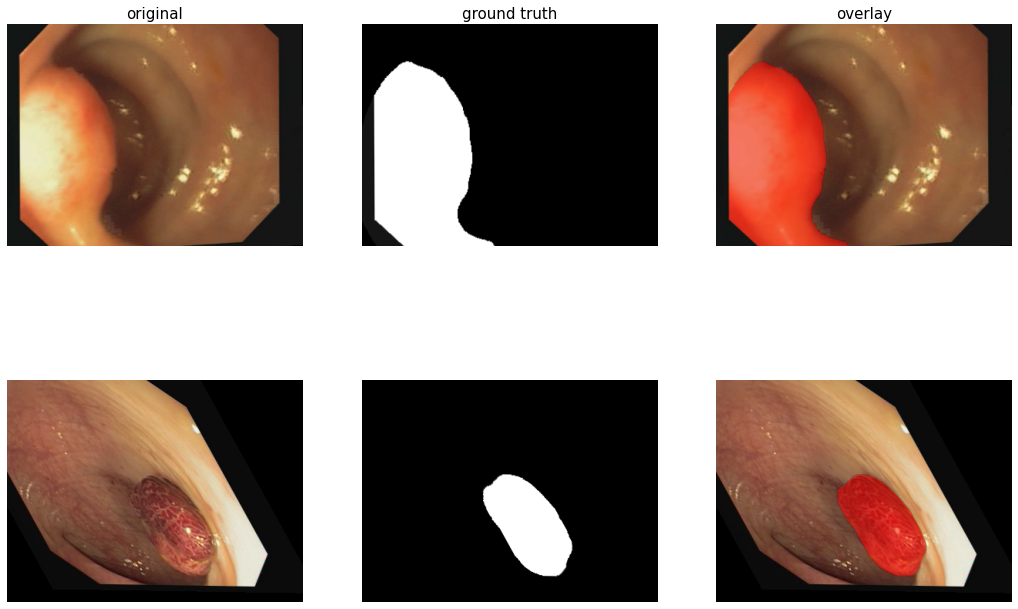

In [18]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [19]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=5
)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 288, 384, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 288, 384, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v3.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [22]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded, dice_coef, 'accuracy', 'sparse_categorical_accuracy']
)

In [23]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=50,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.5717 - iou: 0.1283 - iou_thresholded: 0.2239 - dice_coef: 0.2215 - accuracy: 0.7445 - sparse_categorical_accuracy: 0.8884
Epoch 1: val_loss improved from inf to 501.07574, saving model to segm_model_v3.h5
100/100 [==============================] - 41s 271ms/step - loss: 0.5717 - iou: 0.1283 - iou_thresholded: 0.2239 - dice_coef: 0.2215 - accuracy: 0.7445 - sparse_categorical_accuracy: 0.8884 - val_loss: 501.0757 - val_iou: 0.0788 - val_iou_thresholded: 0.0788 - val_dice_coef: 0.1459 - val_accuracy: 0.6337 - val_sparse_categorical_accuracy: 0.9020
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.3759 - iou: 0.1193 - iou_thresholded: 0.1684 - dice_coef: 0.2082 - accuracy: 0.8782 - sparse_categorical_accuracy: 0.8954
Epoch 2: val_loss improved from 501.07574 to 0.31849, saving model to segm_model_v3.h5
100/100 [==============================] - 14s 143ms/step - loss: 0.3759 - iou: 0.1193 - iou_t

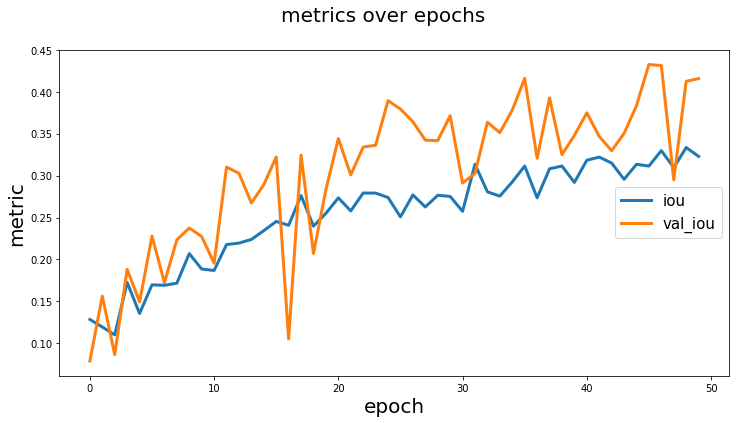

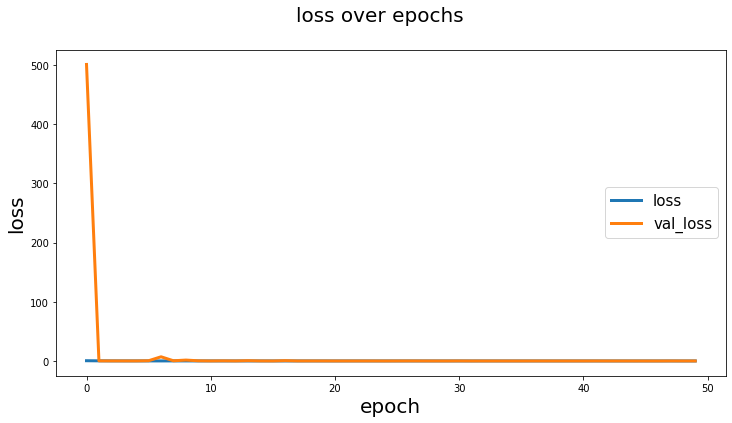

In [24]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [25]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

3/3 [==============================] - 1s 401ms/step


In [26]:
a = y_pred
a_binary = np.zeros(a.shape, dtype=np.bool)
a_binary[a > 0.1] = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


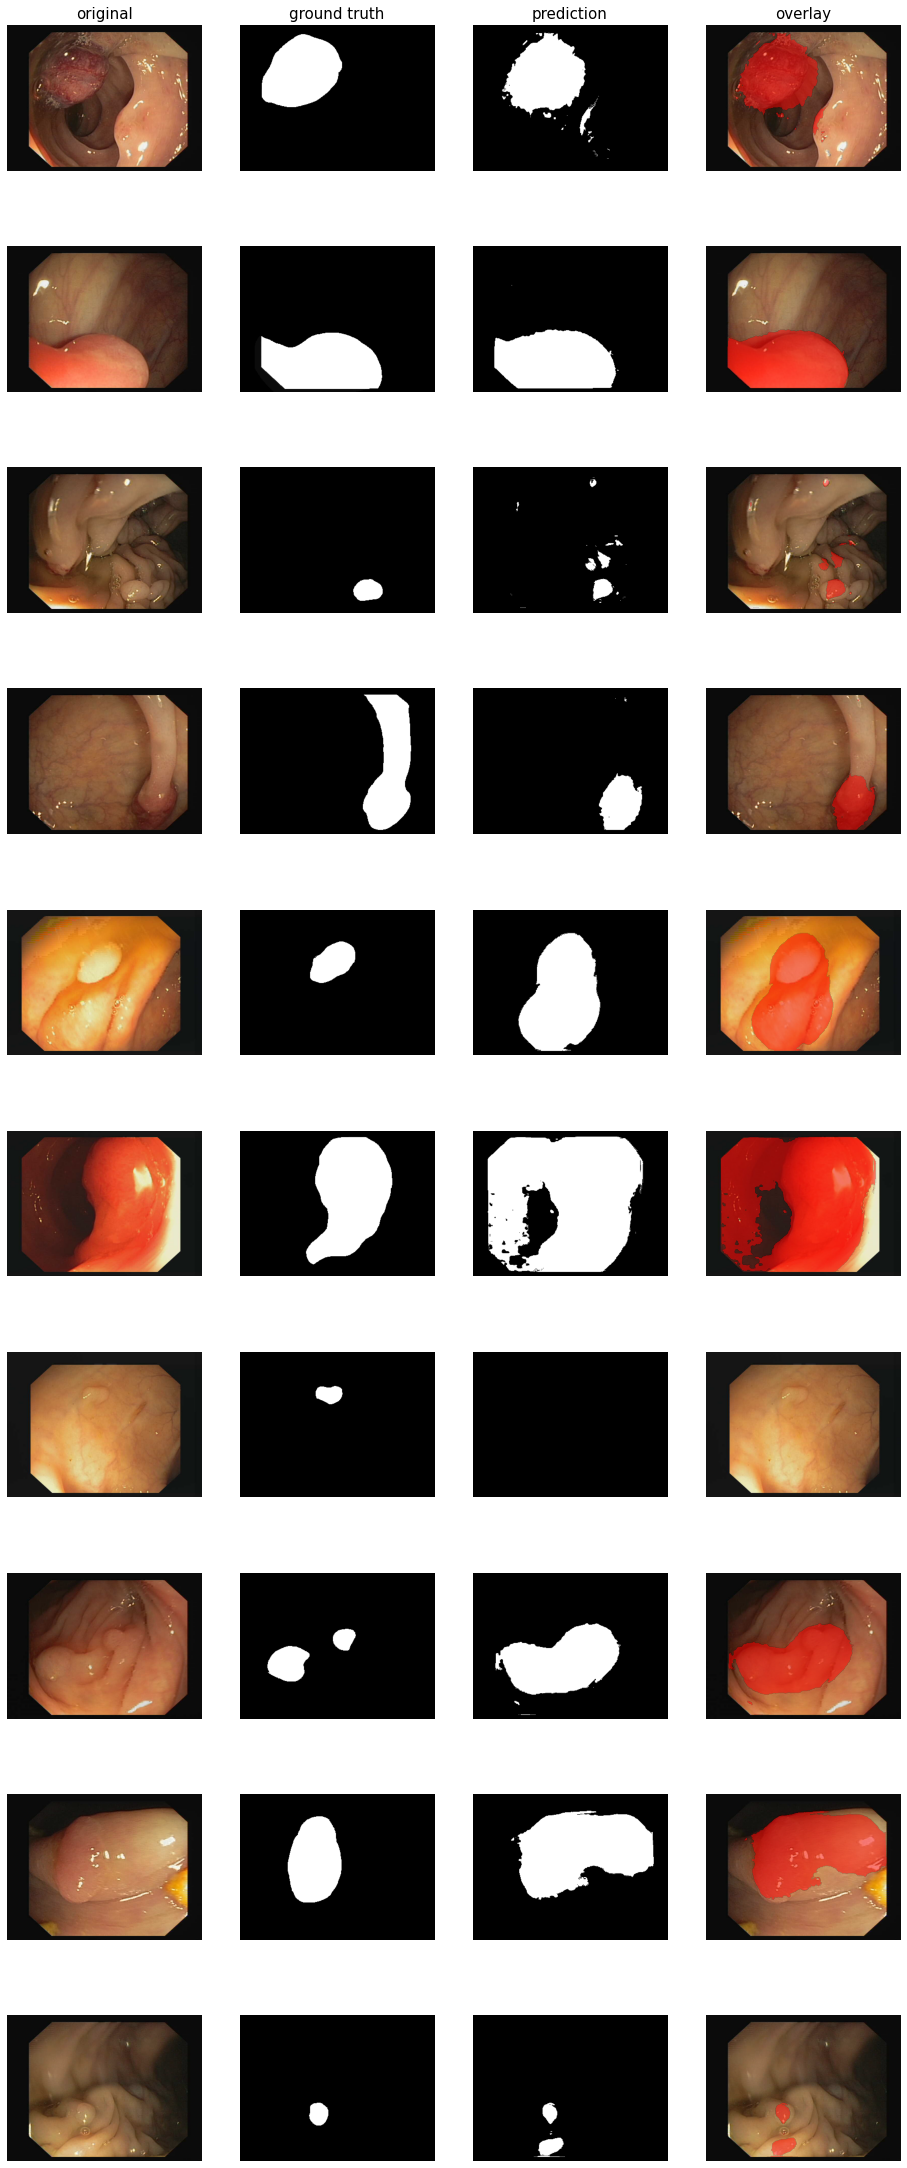

In [27]:
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=a_binary, nm_img_to_plot=10)